**Final Project BA 7374 - Shah & Stolberg**

In [6]:
import math
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
%matplotlib inline

from IPython import display


#import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import scale, StandardScaler, normalize
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pickle
from collections import Counter

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from altair import Chart, X, Y, Axis, SortField

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

**Data Analysis**

In [7]:
#load the dataset
Transac_df = pd.read_excel("Retail_Transactions.xlsx")

In [8]:
Transac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Subject dataset has 541909 rows and 8 attributes. We discovered missing values in the CustomerID and Description column, as it only has 406829 and 540455 values respectively.

In [9]:
Transac_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.0,541909.0,406829.0
mean,9.6,4.6,15287.7
std,218.1,96.8,1713.6
min,-80995.0,-11062.1,12346.0
25%,1.0,1.2,13953.0
50%,3.0,2.1,15152.0
75%,10.0,4.1,16791.0
max,80995.0,38970.0,18287.0


It is important to notice that we have negative values in our dataset. We can safely assume that those transaction with negative values are most likely return transactions. It can be cancelled transactions as well. 
At this point it requires further investigation as to what are these transactions are and what impact it could hold for our analysis. 

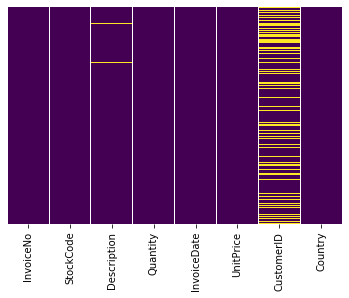

In [10]:
sns.heatmap(Transac_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
## Remove Missing Data
Transac_df = Transac_df.dropna() #remove NaN

In [12]:
# Remove any duplicate entries 
Transac_df.drop_duplicates(inplace = True)

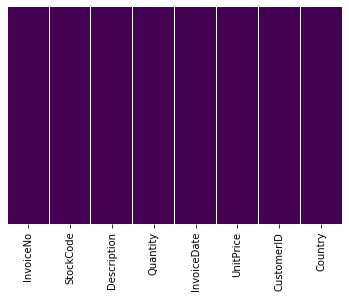

In [13]:
sns.heatmap(Transac_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [14]:
Transac_df.shape

(401604, 8)

In [15]:
#get canceled transactions
Transc_cancel = Transac_df[Transac_df['InvoiceNo'].astype(str).str.contains('C')]
Transc_cancel.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.5,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.7,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.6,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.3,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.3,17548.0,United Kingdom


In [16]:
## Let's find out the quantity 
Transc_cancel[Transc_cancel['Quantity']==-80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.1,16446.0,United Kingdom


In [17]:
Transac_df['total_cost'] = Transac_df['Quantity'] * Transac_df['UnitPrice']

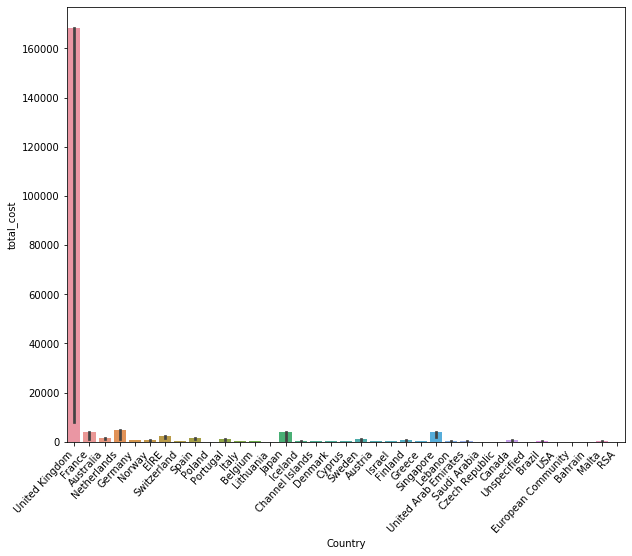

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax=sns.barplot(x='Country', y='total_cost',data=Transac_df,estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

Some of the dataset contains a prefix of "C" and we like to assume that it is used to indicate canclled order. We like to explore the ratio of such orders.  

In [19]:
Transc_cancel[Transc_cancel['Quantity']>0]

print("Total",len(Transc_cancel), " cancelled orders.")

total_orders = Transac_df['InvoiceNo'].nunique()
cancelled_number = len(Transc_cancel)
print('Percentage of orders canceled: {}/{} ({:.2f}%) '.format(cancelled_number, total_orders, cancelled_number/total_orders*100))

Total 8872  cancelled orders.
Percentage of orders canceled: 8872/22190 (39.98%) 


In [20]:
temp_df =Transac_df.groupby(['InvoiceNo','CustomerID'],as_index=False)['InvoiceDate'].count()
transaction_df = temp_df.rename(columns = {'InvoiceDate':'Number of products'})
transaction_df.head()

,InvoiceNo,CustomerID,Number of products
0,536365,17850.0,7
1,536366,17850.0,2
2,536367,13047.0,12
3,536368,13047.0,4
4,536369,13047.0,1


In [21]:
transaction_df.describe()

,CustomerID,Number of products
count,22190.0,22190.0
mean,15238.5,18.1
std,1733.1,23.4
min,12346.0,1.0
25%,13755.0,3.0
50%,15136.0,12.0
75%,16746.0,24.0
max,18287.0,542.0


Let's find out total number of products/SKU or styles. 

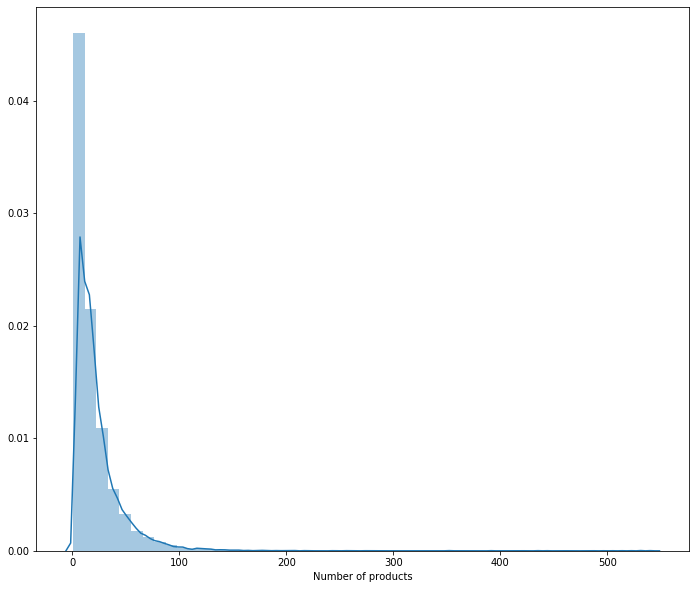

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.distplot(transaction_df['Number of products'],ax=ax)
plt.show()

Clearly, above graph indicates that we have highly skewed distribution as far as customer tend to buy styles/SKU/products from the # of products/styles available for customers to buy. This further strenthens our claims of higher inventory turnover that most retailers suffer, especially the one's who doesn't offer any personlized style recommendation to their customer so that they are motivated to buy different styles that are cater to each customer based on their individual profile preferences. This also helps us understand that most customer buys in-style and very few styles that are in current fashion trends. 

In [23]:
Transac_df.groupby('Country').sum().sort_values(by='total_cost', ascending=False)

,Quantity,UnitPrice,CustomerID,total_cost
Country,,,,
United Kingdom,3994870,1165878.0,5544907004.0,6747156.2
Netherlands,200128,6492.5,34190538.0,284661.5
EIRE,136187,38209.3,110246410.0,250001.8
Germany,117341,37633.4,119881902.0,221509.5
France,109806,42825.2,107441879.0,196626.0
Australia,83643,4048.0,15680571.0,137009.8
Switzerland,29778,6568.6,23775916.0,55739.4
Spain,26817,12621.5,32626727.0,54756.0
Belgium,23152,7540.1,25718288.0,40911.0


Customer by Country

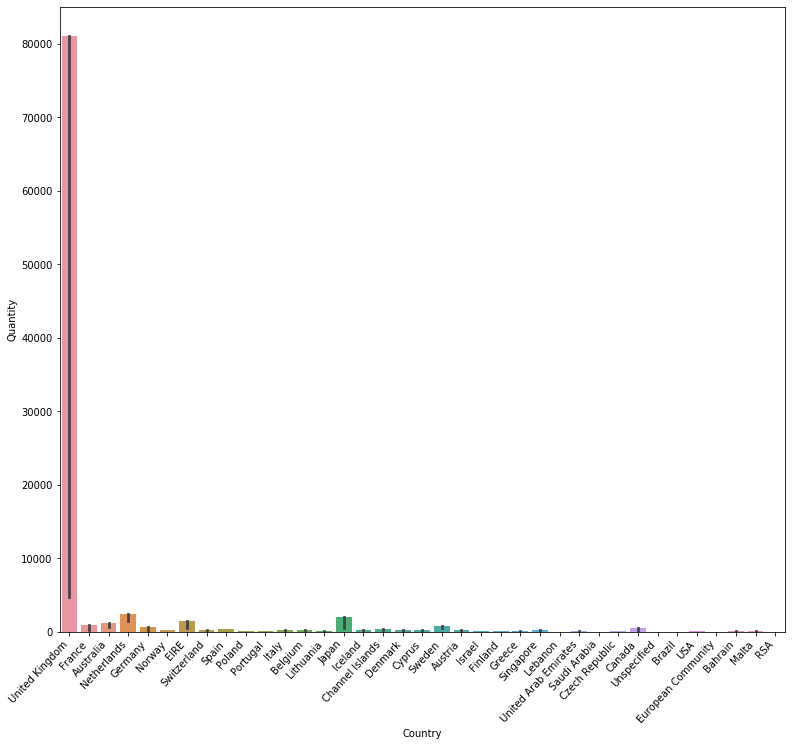

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='Quantity',data=Transac_df,estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

Let's explore products offered. 

In [25]:
groupedProduct = Transac_df.groupby('StockCode',as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
groupedProduct.head(10)

,StockCode,Quantity
2506,84077,53119
1022,22197,48689
3360,85099B,44963
2610,84879,35215
3366,85123A,34185
355,21212,33386
1853,23084,27045
1286,22492,25880
1403,22616,25305
844,21977,24129


AttributeError: 'tuple' object has no attribute 'set_xticklabels'

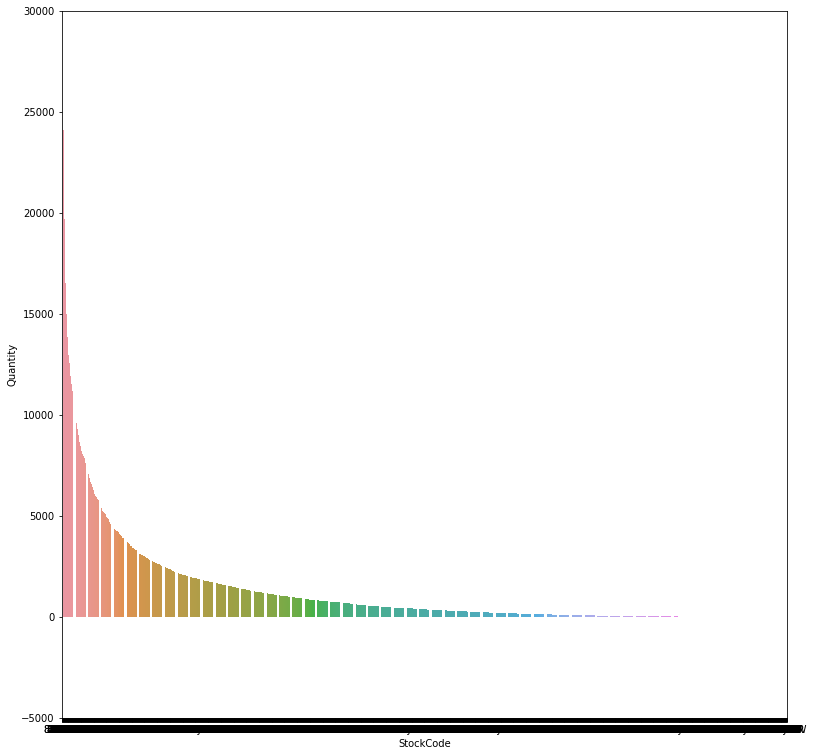

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(13, 13)
ax=sns.barplot(x='StockCode', y='Quantity',data=groupedProduct,estimator=max,ax=ax)
ax = plt.ylim(-5000, 30000)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

**Invoice Summary**

In [27]:
invoice_quantity= Transac_df.groupby('InvoiceNo', as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
invoice_quantity.head()

,InvoiceNo,Quantity
18503,581483,80995
1909,541431,74215
8112,556917,15049
10612,563076,14730
14371,572035,13392


**Exploratory Data Analysis**

In [28]:
Transac_df = Transac_df.sort_values('Quantity', ascending=False)
Transac_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.1,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.0,12346.0,United Kingdom,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,0.0
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.2,12901.0,United Kingdom,1008.0
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.7,13135.0,United Kingdom,3096.0


As we can see from the item descriptoins for top 5 records which appears to be in United Kingdom, where customers have purchased paper craft items. The next item on the list is ceramic storage jar. 

Let's evaluate Unique Item Description.

In [29]:
# Cleaining noise from the description text
Transac_df['Description'] = Transac_df['Description'].str.strip()
descriptors = pd.unique(Transac_df['Description'].values.ravel()).tolist()
print('We discovered',len(descriptors), 'unique descriptors in the Descriptions column.')

We discovered 3885 unique descriptors in the Descriptions column.


In [30]:
descriptors2 = []
for i in range(0,len(descriptors),1):
    text = str(descriptors[i])
    if text == text.upper():
        descriptors2.append(text)
        
print('We also obsereved that there are', len(descriptors2), 'all caps descriptors.')

We also obsereved that there are 3862 all caps descriptors.


In [31]:
# Things does't look correct and may need to be addressed
Problems = ['damages/credits from ASOS.','incorrectly credited C550456 see 47', 
                           'mystery! Only ever imported 1800']

In [32]:
# Let's remove the problems for now.
Transac_df = Transac_df[~Transac_df['Description'].isin(Problems)]

Let's calculate number of unique invoices in our dataaset. 

In [33]:
InvoiceNo = pd.unique(Transac_df['InvoiceNo'].values.ravel()).tolist()
print('We discovered', len(InvoiceNo), 'unique invoice numbers in the dataset.')

We discovered 22190 unique invoice numbers in the dataset.


It is important to visualize these invoices by country to see by conuntry utilization.

In [34]:
Invoice_country = Transac_df.groupby('Country')
Invoice_country.describe()

Quantity                                               \
                        count mean   std      min   25%  50%   75%     max   
Country                                                                      
Australia              1258.0 66.5  97.7   -120.0   6.0 24.0  96.0  1152.0   
Austria                 401.0 12.0  21.7    -48.0   6.0  9.0  12.0   288.0   
Bahrain                  17.0 15.3  25.0      2.0   6.0  6.0   8.0    96.0   
Belgium                2069.0 11.2  13.6    -12.0   4.0 10.0  12.0   272.0   
Brazil                   32.0 11.1   8.5      2.0   3.0 10.0  18.0    24.0   
Canada                  151.0 18.3  46.7      1.0   6.0 12.0  20.0   504.0   
Channel Islands         757.0 12.5  22.6     -2.0   4.0 10.0  12.0   407.0   
Cyprus                  611.0 10.3  23.4    -33.0   2.0  5.0  12.0   288.0   
Czech Republic           30.0 19.7  22.8    -24.0  12.0 24.0  24.0    72.0   
Denmark                 389.0 21.0  27.4    -25.0  12.0 12.0  24.0   256.0   
EIRE                   7475.0 18.2  42.0   -288.0   4.0 10.0  12.0  1440.0   
European Community       61.0  8.1   6.5     -2.0   3.0  6.0  12.0    24.0   
Finland                 695.0 15.3  21.0    -27.0   6.0 10.0  12.0   144.0   
France                 8475.0 13.0  21.5   -250.0   5.0 10.0  12.0   912.0   
Germany                9480.0 12.4  17.9   -288.0   5.0 10.0  12.0   600.0   
Greece                  146.0 10.7   7.7     -1.0   5.2 10.0  12.0    48.0   
Iceland                 182.0 13.5  18.9      2.0   6.0 12.0  12.0   240.0   
Israel                  247.0 16.1  16.7    -32.0   4.0 12.0  24.0   100.0   
Italy                   803.0 10.0  13.6    -12.0   4.0  6.0  12.0   200.0   
Japan                   358.0 70.4 177.2   -624.0   4.0 36.0  72.0  2040.0   
Lebanon                  45.0  8.6   4.3      2.0   6.0  8.0  12.0    24.0   
Lithuania                35.0 18.6  10.1      6.0  12.0 16.0  24.0    48.0   
Malta                   127.0  7.4   8.1     -4.0   3.0  6.0  12.0    48.0   
Netherlands            2371.0 84.4 111.4   -480.0  16.0 72.0 100.0  2400.0   
Norway                 1086.0 17.7  22.6    -12.0   6.0 12.0  24.0   240.0   
Poland                  341.0 10.7  10.2     -6.0   4.0 10.0  12.0    72.0   
Portugal               1471.0 10.9  11.9    -12.0   4.0 10.0  12.0   120.0   
RSA                      58.0  6.1   3.3      1.0   3.0  6.0   9.5    12.0   
Saudi Arabia             10.0  7.5   5.7     -5.0   6.0  9.0  12.0    12.0   
Singapore               229.0 22.9  27.7     -1.0   8.0 12.0  24.0   288.0   
Spain                  2528.0 10.6  24.2   -288.0   3.0  6.0  12.0   360.0   
Sweden                  461.0 77.3 129.0   -240.0   8.0 20.0  96.0   768.0   
Switzerland            1877.0 15.9  19.3   -120.0   6.0 12.0  24.0   288.0   
USA                     291.0  3.6  16.5    -36.0 -10.0  5.0  12.0    72.0   
United Arab Emirates     68.0 14.4  12.5      1.0   6.0 12.0  12.0    72.0   
United Kingdom       356728.0 11.2 265.0 -80995.0   2.0  4.0  12.0 80995.0   
Unspecified             241.0  7.4   8.9      1.0   1.0  2.0  12.0    36.0   

                     UnitPrice                                     CustomerID  \
                         count  mean   std min 25% 50% 75%     max      count   
Country                                                                         
Australia               1258.0   3.2  12.5 0.0 1.2 1.8 3.8   350.0     1258.0   
Austria                  401.0   4.2   7.4 0.1 1.2 1.9 4.2    40.0      401.0   
Bahrain                   17.0   4.6   3.7 1.2 1.6 3.0 5.0    12.8       17.0   
Belgium                 2069.0   3.6   4.2 0.1 1.2 1.9 4.2    40.0     2069.0   
Brazil                    32.0   4.5   2.8 0.8 2.0 3.3 6.8    10.9       32.0   
Canada                   151.0   6.0  44.7 0.1 0.8 1.6 3.0   550.9      151.0   
Channel Islands          757.0   4.9  15.6 0.2 1.4 2.5 6.2   293.0      757.0   
Cyprus                   611.0   6.4  22.6 0.1 1.2 3.0 5.0   320.7      611.0   
Czech Rep

We can conclude from above table that the bulk of the invoicesa are from United Kingdom. 

In [35]:
# group by customer ID and invoice number to create a basket per customer
temp = Transac_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
ProdPerBasket = temp.rename(columns = {'InvoiceDate':'Number of products'})
ProdPerBasket [:10].sort_values('Number of products', ascending=False)

,CustomerID,InvoiceNo,Number of products
7,12347.0,573511,47
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
6,12347.0,562032,22
5,12347.0,556201,18
9,12348.0,539318,17
8,12347.0,581180,11
0,12346.0,541431,1
1,12346.0,C541433,1


**Shopping Cart Abandoning Rate**
We are identifying orders with prefix "C" to analyze the customer behavior who brows the site, try to make purchase by selecting product(s) and then abandon the shopping cart without making a purchase or simply cancels the order. 

In [36]:
print('We discovered that there are:',Transac_df['InvoiceNo'].str.contains("C").sum(), 
      'orders marked with prefix  "C", which contributes',
      (Transac_df['InvoiceNo'].str.contains("C").sum()/len(Transac_df))*100, 
      '% of the dataset.')

We discovered that there are: 8872 orders marked with prefix  "C", which contributes 2.209141343213713 % of the dataset.


We are going to remove these transactions for our analysis moving forward.

In [39]:
# View cancelled orders
cancelled_orders = Transc_cancel[Transc_cancel.InvoiceNo.str.contains("C")]
cancelled_orders.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.5,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.7,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.6,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.3,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.3,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.3,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.5,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.6,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.6,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.2,17897.0,United Kingdom


Negative quantity reflectes the the orders are actually cancelled orders and we will proceed to remove such transactions. 

In [40]:
Cdf1 = pd.DataFrame(cancelled_orders['InvoiceNo'])
Cdf2 = cancelled_orders['InvoiceNo'].str.extract('(\d+)').astype(int)
Cdf1['invoice2'] = Cdf2

**Top Customers**

In [41]:
temp = Transac_df.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].count()
ProdPerBasket = temp.rename(columns = {'InvoiceDate':'Number of products'})
TopBasket = ProdPerBasket.sort_values('Number of products', ascending=False)
TopBasket.head(5)

,CustomerID,Number of products
4042,17841.0,7812
1895,14911.0,5898
1300,14096.0,5128
330,12748.0,4459
1674,14606.0,2759


NameError: name 'grouped' is not defined

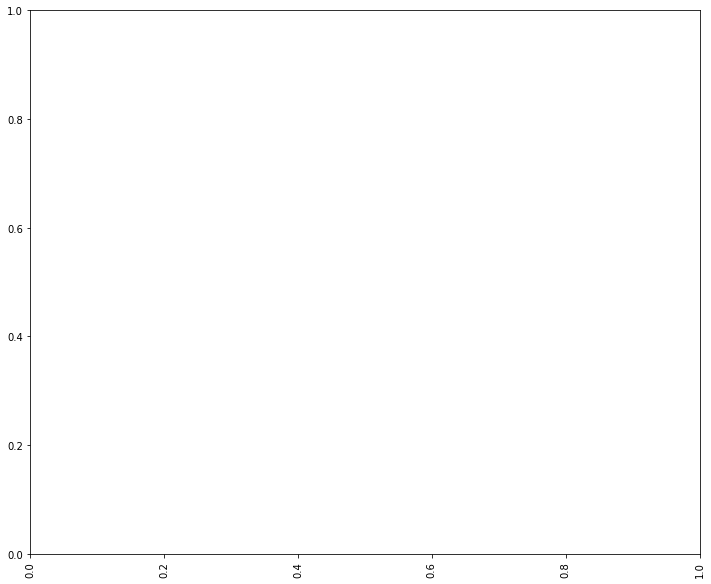

In [48]:
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped['CustomerID'], y=grouped['Number of products'],order=grouped['CustomerID'],color='orange',ci=None)
plt.ylabel('Total Spend', fontsize=13)
plt.xlabel('Top 50 customers', fontsize=13)
plt.show()

In [49]:
TopBasket = Transac_df[Transac_df['CustomerID'] == TopBasket['CustomerID'].iloc[0]]

**Stock Code Analysis**

In [50]:
Stock_Code = (~Transac_df['StockCode'].str.contains('[0-9]',na=False))
unusual_codes = Transac_df.loc[Stock_Code] #filter stock codes with unusueal codes
unusual_codes.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.1,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.0,12346.0,United Kingdom,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,0.0
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.2,12901.0,United Kingdom,1008.0
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.7,13135.0,United Kingdom,3096.0


In [51]:
unusual_codes['StockCode'].unique(), 
print('Total # of Unusual Stock Codes:',len(unusual_codes))

Total # of Unusual Stock Codes: 367960


In [52]:
Transac_df = Transac_df.loc[~Stock_Code]

**Seasonality**

We like to display peaks and valleys of orders in our data set to determin if there is any seasonality present. And therefore we will have to analyze InvoiceDate where we have YYYY-MM-DD & HH:MM:SS information available. 

In [53]:
time_df = list(Transac_df.InvoiceDate)

TimeFrame = pd.DataFrame(pd.to_datetime(time_df), columns=['time'])

In [54]:
Transac_df['time'] = TimeFrame['time'].values


/Users/Dhyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
Transac_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,time
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.4,15749.0,United Kingdom,4632.0,2011-04-18 13:20:00
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.5,15749.0,United Kingdom,4921.5,2011-01-11 12:55:00
6365,536890,17084R,ASSORTED INCENSE PACK,1440,2010-12-03 11:48:00,0.2,14156.0,EIRE,230.4,2010-12-03 11:48:00
160543,550461,47556B,TEA TIME TEA TOWELS,1300,2011-04-18 13:20:00,2.1,15749.0,United Kingdom,2730.0,2011-04-18 13:20:00
52771,540818,47556B,TEA TIME TEA TOWELS,1300,2011-01-11 12:57:00,2.5,15749.0,United Kingdom,3315.0,2011-01-11 12:57:00


/Users/Dhyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.



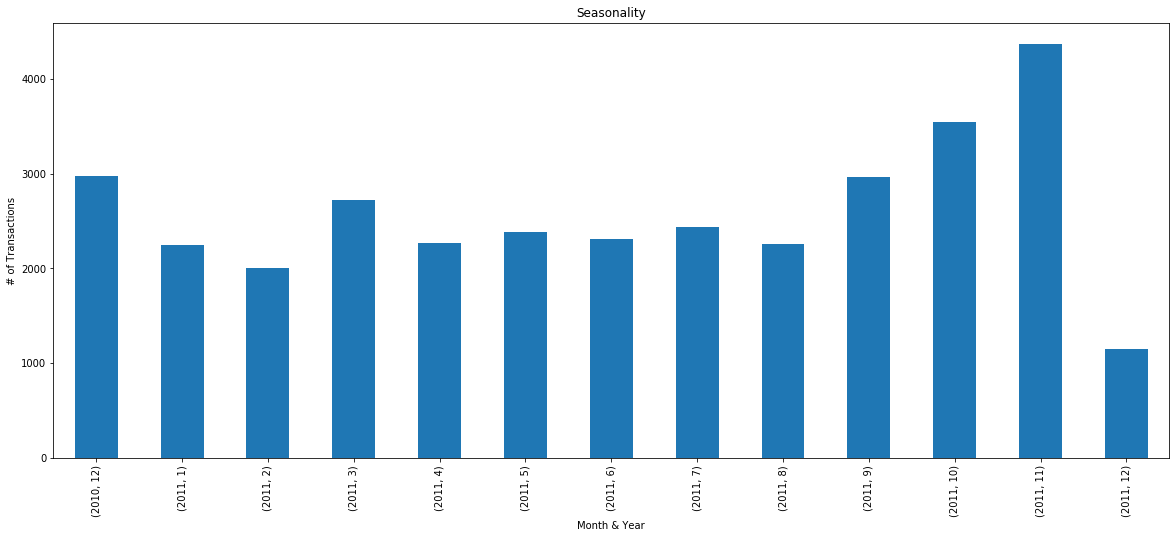

In [56]:
plot_dims = (20, 8)
plot = TimeFrame.groupby((TimeFrame['time'].dt.year, TimeFrame['time'].dt.month.rename('month'))).count().plot(kind="bar",figsize=plot_dims,legend=False)
plot.set(xlabel='Month & Year', ylabel='# of Transactions',title="Seasonality")
plt.xticks(rotation=90)
plt.show()

In [57]:
Seasonality = TimeFrame.groupby((TimeFrame['time'].dt.year, TimeFrame['time'].dt.month.rename('month'))).count()

/Users/Dhyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.



In [65]:
data_plot = [go.Bar(x=Seasonality.index,y=Seasonality.time)]
layout = go.Layout(yaxis={'autorange':True, 'title':'number of invoices received'},xaxis={'type':'category','title':'year, month'},title='invoice timeline')
fig = go.Figure(data=data_plot, layout=layout)
#iplot(fig)
iplot(fig)

**Feature Engineering**

***Total Spend Per Customer***

In [66]:
CustSpend = Transac_df['Quantity'] * Transac_df['UnitPrice']

In [67]:
Transac_df = Transac_df.assign(CustSpend=CustSpend.values)

In [68]:
Transac_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,time,CustSpend
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.4,15749.0,United Kingdom,4632.0,2011-04-18 13:20:00,4632.0
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.5,15749.0,United Kingdom,4921.5,2011-01-11 12:55:00,4921.5
6365,536890,17084R,ASSORTED INCENSE PACK,1440,2010-12-03 11:48:00,0.2,14156.0,EIRE,230.4,2010-12-03 11:48:00,230.4
160543,550461,47556B,TEA TIME TEA TOWELS,1300,2011-04-18 13:20:00,2.1,15749.0,United Kingdom,2730.0,2011-04-18 13:20:00,2730.0
52771,540818,47556B,TEA TIME TEA TOWELS,1300,2011-01-11 12:57:00,2.5,15749.0,United Kingdom,3315.0,2011-01-11 12:57:00,3315.0


In [69]:
grouped = Transac_df.groupby(['Country']).sum()['CustSpend'].sort_values(ascending=False)

In [70]:
data_plot = [go.Bar(x=grouped.index, y=grouped.values)]
layout = go.Layout(yaxis={'autorange':True, 'title':'total order expenditure'},xaxis={'title':'country'},title="total spend per country")
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

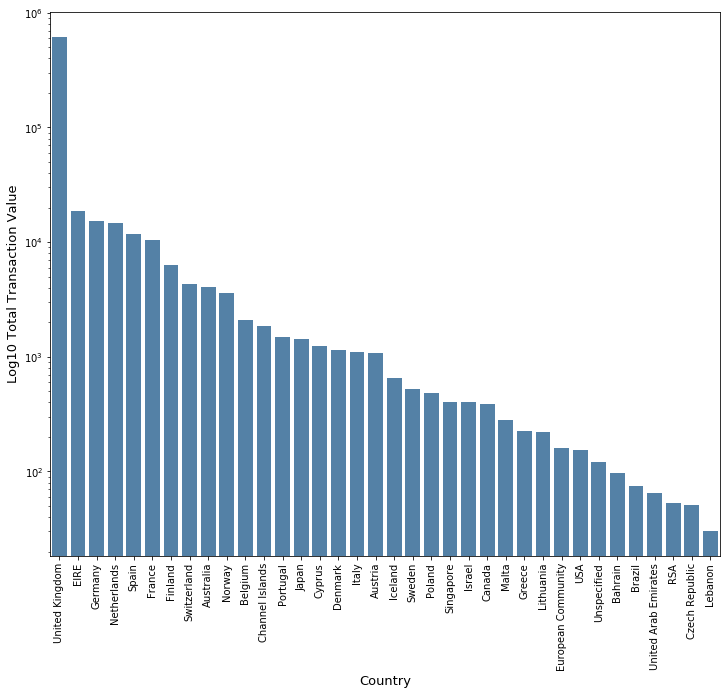

In [71]:
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values, color='steelblue')
f.get_axes()[0].set_yscale('log') 
plt.ylabel('Log10 Total Transaction Value', fontsize=13)
plt.xlabel('Country', fontsize=13)
plt.show()

Taking Log of the transaction data helps overcome the disproportionate transaction from 

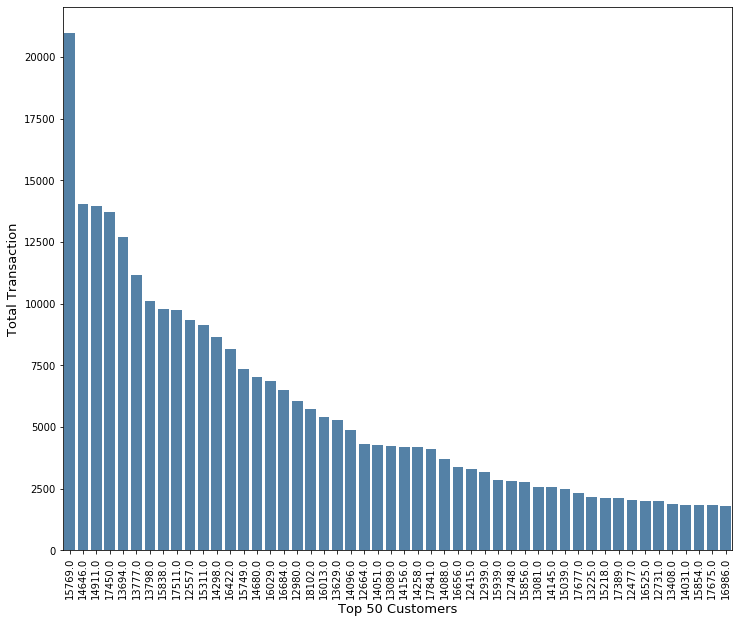

In [72]:
grouped  = Transac_df.groupby(['CustomerID']).sum()['CustSpend'].sort_values(ascending=False)
grouped_top = pd.DataFrame(grouped.head(50))
grouped_top.reset_index(level=0, inplace=True)
grouped_top.sort_values('CustomerID', ascending=False)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped_top['CustomerID'], y=grouped_top['CustSpend'],order=grouped_top['CustomerID'],color='steelblue')
plt.ylabel('Total Transaction', fontsize=13)
plt.xlabel('Top 50 Customers', fontsize=13)
plt.show()

data_plot = [go.Bar(x=grouped_top['CustomerID'], y=grouped_top['CustSpend'])]
layout = go.Layout(yaxis={'autorange':True,'title':'Top 50 Customers'},xaxis={'type':'category','title':'Total Transaction'})
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

***Top 50 Most Spend Transaction***

In [73]:
top_50 = Transac_df[Transac_df['CustomerID'].isin(grouped_top['CustomerID'])]
top_50.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,time,CustSpend
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.4,15749.0,United Kingdom,4632.0,2011-04-18 13:20:00,4632.0
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.5,15749.0,United Kingdom,4921.5,2011-01-11 12:55:00,4921.5
6365,536890,17084R,ASSORTED INCENSE PACK,1440,2010-12-03 11:48:00,0.2,14156.0,EIRE,230.4,2010-12-03 11:48:00,230.4
160543,550461,47556B,TEA TIME TEA TOWELS,1300,2011-04-18 13:20:00,2.1,15749.0,United Kingdom,2730.0,2011-04-18 13:20:00,2730.0
52771,540818,47556B,TEA TIME TEA TOWELS,1300,2011-01-11 12:57:00,2.5,15749.0,United Kingdom,3315.0,2011-01-11 12:57:00,3315.0


***Top 50 Most Spend Transaction by Country***

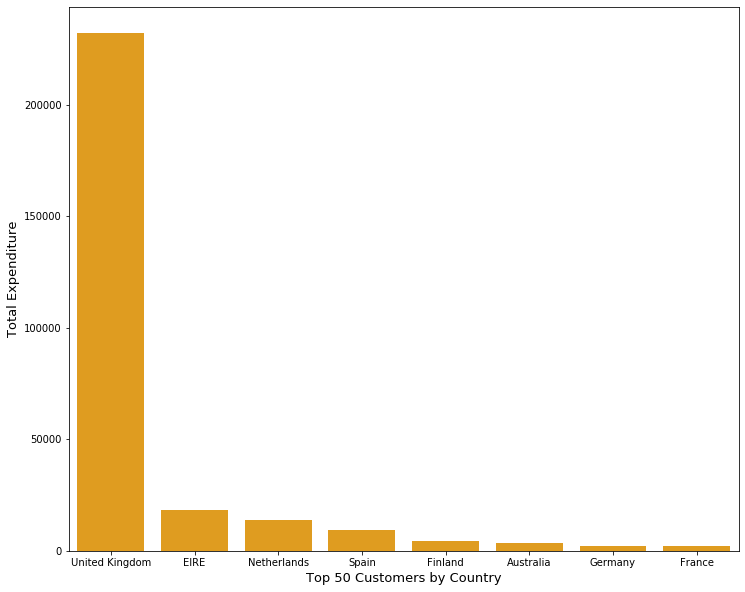

In [74]:
top50_Country  = top_50.groupby(['Country']).sum()['CustSpend'].sort_values(ascending=False)

top50_Country = pd.DataFrame(top50_Country)
top50_Country.reset_index(level=0, inplace=True)
top50_Country.sort_values('Country', ascending=False)

data_plot = [go.Bar(x=top50_Country['Country'], y=top50_Country['CustSpend'])]
layout = go.Layout(yaxis={'autorange':True,'title':'Total Expenditure'},xaxis={'type':'category','title':'country'})
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='horizontal')
sns.barplot(x=top50_Country['Country'], y=top50_Country['CustSpend'],order=top50_Country['Country'],color='orange')
plt.ylabel('Total Expenditure', fontsize=13)
plt.xlabel('Top 50 Customers by Country', fontsize=13)
plt.show()

We Like to identify each transactions and rank each one based on their lifetime spend.

In [75]:
Ranking = []
for i in range(0,len(Transac_df),1):
    if Transac_df['CustSpend'].iloc[i] < 10000:
        Ranking.append(1)
    elif Transac_df['CustSpend'].iloc[i] >50000:
        Ranking.append(3)
    else:
        Ranking.append(2)

In [76]:
Transac_df['Ranking'] = Ranking

In [77]:
len(Transac_df.StockCode.unique()), len(Transac_df.Description.unique())

(879, 889)

In [78]:
Transac_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,time,CustSpend,Ranking
160542,550461,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.4,15749.0,United Kingdom,4632.0,2011-04-18 13:20:00,4632.0,1
52709,540815,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.5,15749.0,United Kingdom,4921.5,2011-01-11 12:55:00,4921.5,1
6365,536890,17084R,ASSORTED INCENSE PACK,1440,2010-12-03 11:48:00,0.2,14156.0,EIRE,230.4,2010-12-03 11:48:00,230.4,1
160543,550461,47556B,TEA TIME TEA TOWELS,1300,2011-04-18 13:20:00,2.1,15749.0,United Kingdom,2730.0,2011-04-18 13:20:00,2730.0,1
52771,540818,47556B,TEA TIME TEA TOWELS,1300,2011-01-11 12:57:00,2.5,15749.0,United Kingdom,3315.0,2011-01-11 12:57:00,3315.0,1


**TotalSpend by Customer**

In [79]:
CustGrp = Transac_df.groupby('CustomerID')
data_cluster=pd.DataFrame(columns=['Quantity','UnitPrice', 'total_spend', 'CustomerID'])
count=0

In [80]:
for k,v in (CustGrp):
    data_cluster.loc[count] = [(v['Quantity'].sum()), v['UnitPrice'].sum(), v['CustSpend'].sum(), k]
    count+=1

# K-Means Clustering on quantity, and total spend
X = data_cluster.iloc[:, [0, 2]].values

In [81]:
data_cluster.head()

,Quantity,UnitPrice,total_spend,CustomerID
0,321.0,47.0,656.6,12347.0
1,19.0,52.6,85.1,12349.0
2,28.0,4.7,36.4,12350.0
3,10.0,1.2,12.5,12352.0
4,4.0,4.2,16.6,12354.0


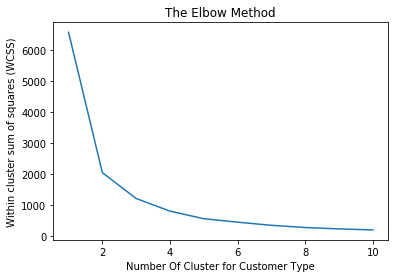

In [82]:
from sklearn.preprocessing import StandardScaler
X_cluster = StandardScaler()
X= X_cluster.fit_transform(X)

#Elbow method to find the optimum number of clusters

from sklearn.cluster import KMeans
wcss = [] #Within cluster sum of squares (inertia)


for i in range(1,11): #From 2-10 doing multiple random initializations can make a huge difference to find a better local optima
    kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11) , wcss)
plt.title('The Elbow Method')
plt.xlabel('Number Of Cluster for Customer Type')
plt.ylabel('Within cluster sum of squares (WCSS)')
plt.show()

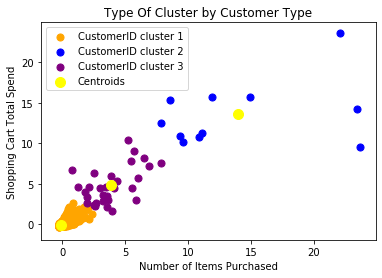

In [83]:
# Fitting K-Means to the dataset
KM_Cluster = KMeans(n_clusters = 3, init = 'k-means++')
KM_y = KM_Cluster.fit_predict(X)

# Visualising the clusters
plt.scatter(X[KM_y == 0, 0], X[KM_y == 0, 1], s = 50, c = 'orange', label = 'CustomerID cluster 1')
plt.scatter(X[KM_y == 1, 0], X[KM_y == 1, 1], s = 50, c = 'blue', label = 'CustomerID cluster 2')
plt.scatter(X[KM_y == 2, 0], X[KM_y == 2, 1], s = 50, c = 'purple', label = 'CustomerID cluster 3')
plt.scatter(KM_Cluster.cluster_centers_[:, 0], KM_Cluster.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Type Of Cluster by Customer Type')
plt.xlabel('Number of Items Purchased')
plt.ylabel('Shopping Cart Total Spend')
plt.legend()
plt.show()
